### Experiment for Quant-UCB

#### Test for design of upper quantile

Finite arm setting (two arms):  

Arm one: normal distribution with mean 0.72 and variance 1:  
Mean 0.72 Median 0.72  

Arm two: [skewed normal distribution](https://en.wikipedia.org/wiki/Skew_normal_distribution) with skewness 4
Standard skewed normal distribution
$$f(x) = 2\phi(x)\Phi(\alpha x)$$
where $\phi(x)$ is the standard normal pdf, $\Phi(x)$ is the standard normal cdf.  
Mean 0.77 Median 0.67  

Plotting are given below.

#### Selection rule for quantile ucb

$$\text{action} = argmax \quad q_{\alpha_t}(\text{reward})$$
where $q_{\alpha_t}$ is the upper quantile. Some choices of $\alpha_t$ (n is the total number of iterations): 

Linear limit: $\alpha_t = 0.5 + t/(2n)$    
Square limit: $\alpha_t = 0.5 + t^2/(2n^2)$    
Log: $\alpha_t = log(t + 1)/n$        
Loge limit: $\alpha_t = 0.5 + log(t + 1)/(2n)$

#### Definition of the measurement

For multi-armed bandit problem, we usually define:  
best action: choosing the arm with the maximum expected cumulative reward.   
cumulative regret: cumulative reward of best action - cumulative reward of selected action

For quantile ucb, I show the cumulative regret for each upper quantile design vs number of iterations.
To compare, I also show the performance of the ucb1.
The regret is computed as the expected value of 50 experiments, where each experiment has 10000 iterations.

#### Things to discuss

1. How to design experiments? For example, why use skewed distribution here. What properties of quantile-ucb do we want to show according to that? 
2. How to define the best action? why expectation rather than median?
3. How to intepret the plotting results? 

#### Todos
1. Other possible quantile ucb selection rules.
2. CVaR ucb design
3. Compare with quantile ucb and CVaR
4. the case for continuous arms. 

In [1]:
from scipy.stats import skewnorm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import defaultdict
import math

### skew normal distribution

In [2]:
NUM_SAMPLES = 10000
SKEW_PARAMS = 4

def rand_skew_norm(fAlpha, fLocation, fScale):
    sigma = fAlpha / np.sqrt(1.0 + fAlpha**2) 

    afRN = np.random.randn(2)
    u0 = afRN[0]
    v = afRN[1]
    u1 = sigma*u0 + np.sqrt(1.0 -sigma**2) * v 

    if u0 >= 0:
        return u1*fScale + fLocation 
    return (-u1)*fScale + fLocation 

def randn_skew(N, skew=0.0):
    return [rand_skew_norm(skew, 0, 1) for x in range(N)]

### visualize the normal and skew normal distribution

For normal distribution:
mean: 0.006286, median: 0.002573
1.002109588862522

For skewed normal distribution:
mean: -0.773170, median: -0.676197
-0.16288505212947835

For skewed normal distribution:
mean: 0.002385, median: -0.002260
1.0008428411182713


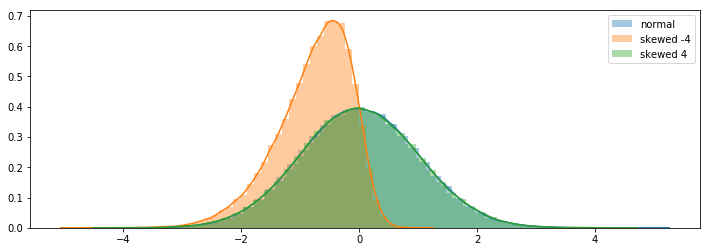

In [15]:
def quantile(data, alpha):
    '''
    return the alpha-quantile for given data samples
    '''
    data = np.sort(data)
    idx = int(len(data) * alpha) - 1
    return data[idx]

plt.subplots(figsize=(12,4))

# normal 
n = np.random.normal(0,1, NUM_SAMPLES)
print('For normal distribution:')
print('mean: %f, median: %f' % (np.mean(n), np.median(n)))
print(quantile(n, 0.84))

#for alpha_skew in SKEW_PARAMS:
p1 = randn_skew(NUM_SAMPLES, -4)
print()
print('For skewed normal distribution:')
print('mean: %f, median: %f' % (np.mean(p1), np.median(p1)))
print(quantile(p1, 0.84))

#for alpha_skew in SKEW_PARAMS:
p2 = randn_skew(NUM_SAMPLES, 0)
print()
print('For skewed normal distribution:')
print('mean: %f, median: %f' % (np.mean(p2), np.median(p2)))
print(quantile(p2, 0.84))

sns.distplot(n, label = 'normal')
sns.distplot(p1, label = 'skewed -4')
sns.distplot(p2, label = 'skewed 4')
plt.legend()

### visualize the simulated arm distribution

For normal distribution:
mean: 0.722194, median: 0.722261

For skewed normal distribution:
mean: 0.775910, median: 0.674856


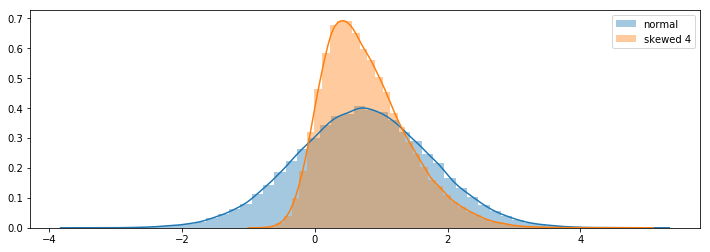

In [4]:
# carefully choose parameters to let skew normal have larger mean and smaller median

plt.subplots(figsize=(12,4))

# normal 
n = np.random.normal(0.72,1, NUM_SAMPLES)
print('For normal distribution:')
print('mean: %f, median: %f' % (np.mean(n), np.median(n)))

#for alpha_skew in SKEW_PARAMS:
p = randn_skew(NUM_SAMPLES, 4)
print()
print('For skewed normal distribution:')
print('mean: %f, median: %f' % (np.mean(p2), np.median(p2)))

sns.distplot(n, label = 'normal')
sns.distplot(p, label = 'skewed 4')
plt.legend()

In [5]:
# settings

num_exper = 100
num_rounds = 5000
loc = 0.72
scale = 1
alpha_skew = 4

In [6]:
def quantile(data, alpha):
    '''
    return the alpha-quantile for given data samples
    '''
    data = np.sort(data)
    idx = int(len(data) * alpha) - 1
    return data[idx]

def CVaR(data, a):
    '''
    return the alpha-CVaR for given data samples
    '''
    data = np.sort(data)
    # idx = int(data.shape[0] * a)
    idx = int(len(data) * a)
    CVaR = np.mean(data[idx:])
    return CVaR

arm_name = ['normal', 'skewed']

mu_bestarm = 0.776256

def quant_ucb_with_expectation(num_rounds, loc, scale, alpha_skew, level):
    '''
    Quantile UCB experiment:
    selet the arm with the maximum upper quantile
    the design upper quantile is a function about 'num_rounds' and specified by 'level' function 
    
    Returns the cumulative regret list
    Cumulative regret is defined by the difference of the cumulative reward of the best action 
    (the action with the maximum expected reward) and the cumulative reward of the selected action.
    '''
    rewards = defaultdict(list)
    ucbs = defaultdict(list)
    
    # initialize empirical reward
    rewards['normal'].append(np.random.normal(loc, scale)) 
    rewards['skewed'].append(randn_skew(1, alpha_skew)[0])
    
    # define best action as skewed arm since it has larger expected value
    cumulativeReward = 0
    bestActionCumulativeReward = 0
    Regret_list = []
    selection = {}
    alpha = defaultdict(list)
    
    #for level in quantile_level_choice:
    for i in range(2, num_rounds):
        for arm in arm_name:
            alpha[arm].append(np.sqrt(np.log(i+1)/selection.get(arm, 1)))
            ucbs[arm] = np.mean(rewards[arm]) + quantile(rewards[arm], level(i, selection.get(arm, 1)))
            #ucbs[arm] = quantile(rewards[arm], level(i, selection.get(arm, 1)))
        if ucbs['normal'] > ucbs['skewed']:
            theReward = np.random.normal(loc, scale, 1)[0]
            rewards['normal'].append(theReward)
            selection['normal'] = selection.get('normal', 1) + 1
            bestActionCumulativeReward += randn_skew(1, alpha_skew)[0]
            #bestActionCumulativeReward += theReward
        else:
            theReward = randn_skew(1, alpha_skew)[0]
            rewards['skewed'].append(theReward)
            selection['skewed'] = selection.get('skewed', 1) + 1
            bestActionCumulativeReward += theReward
            #bestActionCumulativeReward += np.random.normal(loc, scale, 1)[0]
        #bestActionCumulativeReward += mu_bestarm
        cumulativeReward += theReward
        regret = bestActionCumulativeReward - cumulativeReward
        Regret_list.append(regret)
            
    return Regret_list, selection, alpha

### QuantUCB with different upper quantile choices

In [7]:
# Report the how cumulative reward changed in terms of different alpha level design

Regret_dict = defaultdict(list)
selection_dict = defaultdict(list)

def loge(t, num_rounds):
    return np.log(t + 1)/num_rounds
def log2(t, num_rounds):
    return np.log2(t + 1)/num_rounds
def log10(t, num_rounds):
    return np.log10(t + 1)/num_rounds

def loge_limit(t, num_rounds):
    #return 0.5 + np.log(t + 1)/(num_rounds * 2)
    return np.log(t + 1)/(num_rounds * 2)
    #return 1 - np.log(t+1)/20
    
def loge_nj(t, n_selected):
    alpha = np.sqrt(np.log(t+1)/n_selected)
    if alpha >= 1:
        return 0.8
    else: 
        return alpha
    #elif alpha > 0.1:
        #print('in %d iteration, alpha is %f', (t, alpha))
    #    return alpha
    #elif alpha < 0.1:
    #    return 0.1

level_list = [loge_nj]
level_name = ['loge_nj']

for exper in range(num_exper):
    for i, level in enumerate(level_list):
        regret, selection, alpha = quant_ucb_with_expectation(num_rounds, loc, scale, alpha_skew, level)
        Regret_dict[level_name[i]].append(regret)
        #selection_dict[level_name[i]].append(selection)
        #Regret_list = quant_ucb(num_rounds, loc, scale, alpha_skew, level)

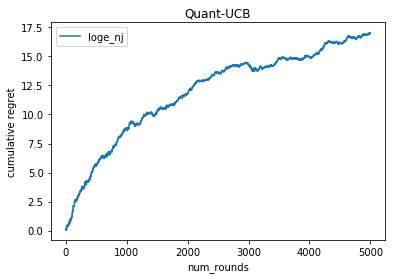

In [12]:
for key, value in Regret_dict.items():
    value = np.asarray(value)
    ave_regret = np.average(value, axis = 0)
    plt.plot(ave_regret, label = key)
    
plt.ylabel('cumulative regret')
plt.xlabel('num_rounds')
plt.title('Quant-UCB')
plt.legend()
plt.savefig('QuantUCB.png')

### UCB1

In [9]:
# compare with UCB1 algorithm

def upperBound(step, numPlays):
    ub = math.sqrt(2 * math.log(step + 1) / numPlays)
    return ub
    #elif ub > 0.1:
    #    return ub
    #else:
    #    return 0.1

def ucb1(num_rounds, loc, scale, alpha_skew):
    rewards = {}
    numPlays = {}
    
    # initialize empirical reward
    rewards['normal'] = np.random.normal(loc, scale, 1)[0]
    rewards['skewed'] = randn_skew(1, alpha_skew)[0]
    numPlays['normal'] = 1
    numPlays['skewed'] = 1

    # define best action as skewed arm since it has larger expected value
    cumulativeReward = 0
    bestActionCumulativeReward = 0
    Regret_list = []
    selected_action = []

    for i in range(2, num_rounds):
        if rewards['normal']/numPlays['normal'] + upperBound(i, numPlays['normal']) \
                > rewards['skewed']/numPlays['skewed'] + upperBound(i, numPlays['skewed']):
            theReward = np.random.normal(loc, scale, 1)[0]
            numPlays['normal'] += 1
            rewards['normal'] += theReward
            bestActionCumulativeReward += randn_skew(1, alpha_skew)[0]
            #bestActionCumulativeReward += theReward
            selected_action.append(1)
        else:
            theReward = randn_skew(1, alpha_skew)[0]
            numPlays['skewed'] += 1
            rewards['skewed']+= theReward
            bestActionCumulativeReward += theReward
            #bestActionCumulativeReward += np.random.normal(loc, scale, 1)[0]
            selected_action.append(2)
        #cumulativeReward += theReward
        #regret = bestActionCumulativeReward - cumulativeReward
        #Regret_list.append(regret)
        #bestActionCumulativeReward += mu_bestarm
        cumulativeReward += theReward
        regret = bestActionCumulativeReward - cumulativeReward
        Regret_list.append(regret)

    return Regret_list, selected_action 

#Regret_list = ucb1(num_rounds, loc, scale, alpha_skew)

In [10]:
Regret_list = []
for exper in range(num_exper):
    for i, level in enumerate(level_list):
        regret, selected_action = ucb1(num_rounds, loc, scale, alpha_skew)
        Regret_list.append(regret)
        #print(selected_action)
        #Regret_list = quant_ucb(num_rounds, loc, scale, alpha_skew, level)
    
regret = np.asarray(Regret_list)
ave_regret = np.average(regret, axis = 0)
#plt.plot(ave_regret)


/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


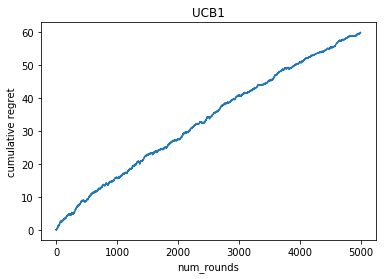

In [11]:
plt.plot(ave_regret)
plt.ylabel('cumulative regret')
plt.xlabel('num_rounds')
plt.title('UCB1')
    
plt.legend()
plt.savefig('UCB1.png')